In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt #To plot the reduction in error
import sklearn # To plot ROC
from sklearn import metrics #To plot confusion matrix
import seaborn as sns #Heat map used for confusion matrix
from mnist import MNIST # To unload the ubyte data - Image data set

In [2]:
# Load the data set
mndata = MNIST('samples')
images1, labels1 = mndata.load_training()
# or
images2, labels2 = mndata.load_testing()

In [3]:
train = pd.DataFrame(images1)
train['Target'] = labels1
test = pd.DataFrame(images2)
test['Target'] = labels2

In [4]:
train = train.loc[(train['Target'] == 3) | (train['Target'] == 9)]
test = test.loc[(test['Target'] == 3) | (test['Target'] == 9)]

In [5]:
train_y = train["Target"]
train_x = train.drop(['Target'], axis=1).as_matrix()
test_y = test["Target"]
test_x = test.drop(['Target'], axis=1).as_matrix()
train_x = sklearn.preprocessing.normalize(train_x, norm='max')
test_x = sklearn.preprocessing.normalize(test_x, norm='max')

In [6]:
# Converting to numpy array
train_y = np.asarray(train_y).reshape(len(train_y), 1)
test_y = np.asarray(test_y).reshape(len(test_y), 1)
train_y = np.where(train_y == 3, 0, 1).reshape(len(train_y), 1)
test_y = np.where(test_y == 3, 0, 1).reshape(len(test_y), 1)

In [41]:
train_x = train_x[:7000]
train_y = train_y[:7000]
test_x = test_x[:1000]
test_y = test_y[:1000]

In [60]:
#0.02 and 300
class NeuralNet():
    def __init__(self, train_x, train_y, test_x, 
                 test_y, hidden_layers = 2, hidden_node = 400, learning_rate=0.02, epoch=10, regParam=0.005):
        self.op_node = 1
        self.learning_rate= learning_rate
        self.hidden_node = hidden_node
        self.hidden_layers = hidden_layers
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.input_node = train_x.shape[1]
        self.epoch = epoch
        self.train_predict = None
        self.error = None
        self.test_predict = None
        self.regParam = regParam


        # Weights
        #np.random.seed(3)
        if self.hidden_layers == 1:
            self.w1_ly1 = np.random.randn(self.input_node, self.hidden_node)
            self.b1_ly1 = np.zeros((1, self.hidden_node))
            self.w2_ly2 = np.random.randn(self.hidden_node, self.op_node)
            self.b2_ly2 = np.zeros((1, self.op_node))
        
        if self.hidden_layers == 2:
            self.w1_ly1 = np.random.randn(self.input_node, self.hidden_node)
            self.b1_ly1 = np.zeros((1, self.hidden_node))
            self.w2_ly2 = np.random.randn(self.hidden_node, self.hidden_node)
            self.b2_ly2 = np.zeros((1, self.hidden_node))
            self.w3_ly3 = np.random.randn(self.hidden_node, self.op_node)
            self.b3_ly3 = np.zeros((1, self.op_node))
            
            
    def activation(self, z):
        return 1 / (1 + np.exp(-z))
        
    
    def gradient_descent(self, tdelta1, tdelta2, tb1, tb2, tdelta3=0, tb3=0):
        if self.hidden_layers == 1:
            self.w1_ly1 = self.w1_ly1 - self.learning_rate*(tdelta1 + (self.regParam * self.w1_ly1))
            self.w2_ly2 = self.w2_ly2 - self.learning_rate*(tdelta2 + (self.regParam * self.w2_ly2))
            self.b1_ly1 = self.b1_ly1 - self.learning_rate*tb1
            self.b2_ly2 = self.b2_ly2 - self.learning_rate*tb2
            
        if self.hidden_layers == 2:
            self.w1_ly1 = self.w1_ly1 - self.learning_rate*(tdelta1 + (self.regParam * self.w1_ly1))
            self.w2_ly2 = self.w2_ly2 - self.learning_rate*(tdelta2 + (self.regParam * self.w2_ly2))
            self.w3_ly3 = self.w3_ly3 - self.learning_rate*(tdelta3 + (self.regParam * self.w3_ly3))
            self.b1_ly1 = self.b1_ly1 - self.learning_rate*tb1
            self.b2_ly2 = self.b2_ly2 - self.learning_rate*tb2
            self.b3_ly3 = self.b3_ly3 - self.learning_rate*tb3
        
        
    def trainNN(self):
        rmse = []
        for ep in range(self.epoch):
            errort = []
            hyp = []
            cnt = 0
            
            for row in self.train_x:
                row = row.reshape(1, len(row))
                
                if self.hidden_layers == 1:
                    #Forward Feed
                    a1 = row
                    z2 = np.dot(a1, self.w1_ly1) + self.b1_ly1
                    a2 = self.activation(z2)
                    z3 = np.dot(a2, self.w2_ly2) + self.b2_ly2
                    a3 = self.activation(z3)
                    error = a3 - self.train_y

                    #mean_error = np.sum(error)/len(error)
                    #rmse.append(mean_error)

                    #Backward propogation
                    delta2 = error*a3*(1-a3)  # a3*(1-a3) is same as derivative of sigmoid finction
                    delta1 = np.dot(delta2, self.w2_ly2.T)*a2*(1 - a2)
                    tdelta2 = np.dot(a2.T, delta2)
                    tdelta1 = np.dot(row.T, delta1)
                    tb2 = np.sum(delta2, axis=0).reshape(1, self.op_node)
                    tb1 = np.sum(delta1,axis=0).reshape(1, self.hidden_node)
                    self.gradient_descent(tdelta1, tdelta2, tb1, tb2)
                    self.train_predict = a3

                if self.hidden_layers == 2:
                    #Forward Propogation
                    a1 = row
                    z2 = np.dot(a1, self.w1_ly1) + self.b1_ly1
                    a2 = self.activation(z2)
                    z3 = np.dot(a2, self.w2_ly2) + self.b2_ly2
                    a3 = self.activation(z3)
                    z4 = np.dot(a3, self.w3_ly3) + self.b3_ly3
                    a4 = self.activation(z4)
                    error = a4 - self.train_y[cnt]

                    errort.append(error)
                    

                    #Backward propogation
                    delta3 = error*a4*(1-a4)
                    delta2 = np.dot(delta3, self.w3_ly3.T)*a3*(1 - a3)
                    delta1 = np.dot(delta2, self.w2_ly2.T)*a2*(1 - a2)
                    tdelta3 = np.dot(a3.T, delta3)
                    tdelta2 = np.dot(a2.T, delta2)
                    tdelta1 = np.dot(row.T, delta1)
                    tb3 = np.sum(delta3, axis=0).reshape(1, self.op_node)
                    tb2 = np.sum(delta2,axis=0).reshape(1, self.hidden_node)
                    tb1 = np.sum(delta1,axis=0).reshape(1, self.hidden_node)
                    self.gradient_descent(tdelta1, tdelta2, tb1, tb2, tdelta3, tb3)
                    hyp.append(a4)
                    cnt = cnt + 1
                    #print(cnt)
                
                self.error = np.asarray(errort)
                self.train_predict = np.asarray(hyp)
                
            if ep in [1,2, 4, 6, 7, 8, 9, 70, 100, 140, 200, 500, 800, 999, 1500, 2000, 2500, 2999]:
                accuracy = 1-np.sum(abs(np.asarray(errort)))/len(np.asarray(errort))
                print("Accuracy is:  {0:.4f}, for epoch:{1}".format(accuracy, ep))
                    
        self.rmse = rmse
        
        
    def predict_digit(self):
        
        if self.hidden_layers == 1:
                #Forward Feed
                a1 = self.test_x
                z2 = np.dot(a1, self.w1_ly1) + self.b1_ly1
                a2 = self.activation(z2)
                z3 = np.dot(a2, self.w2_ly2) + self.b2_ly2
                a3 = self.activation(z3)
                
                self.test_predict = np.round(a3)
        
        if self.hidden_layers == 2:
                #Forward Propogation
                a1 = self.test_x
                z2 = np.dot(a1, self.w1_ly1) + self.b1_ly1
                a2 = self.activation(z2)
                z3 = np.dot(a2, self.w2_ly2) + self.b2_ly2
                a3 = self.activation(z3)
                z4 = np.dot(a3, self.w3_ly3) + self.b3_ly3
                a4 = self.activation(z4)
                
                self.test_predict = np.round(a4)

Accuracy is:  0.9240, for epoch:1
Accuracy is:  0.8792, for epoch:2
Accuracy is:  0.8256, for epoch:4
Accuracy is:  0.8208, for epoch:6
Accuracy is:  0.8207, for epoch:7
Accuracy is:  0.8207, for epoch:8
Accuracy is:  0.8207, for epoch:9


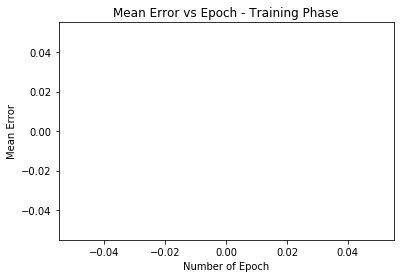

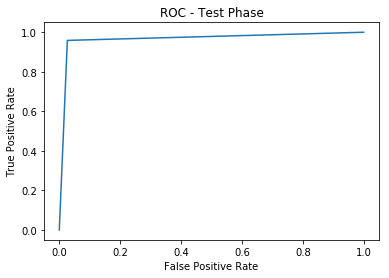

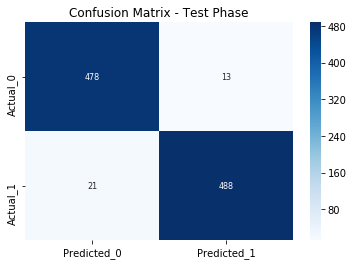

Test Accuracy:  0.966


In [61]:
def main():
    new = NeuralNet(train_x, train_y, test_x, test_y)
    new.trainNN()
    new.predict_digit()

    plt.plot(new.rmse)
    plt.title("Mean Error vs Epoch - Training Phase")
    plt.xlabel("Number of Epoch")
    plt.ylabel("Mean Error")
    plt.show()

    
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(new.test_y, new.test_predict, 
                                                     pos_label=None, sample_weight=None, drop_intermediate=True)
    plt.plot(fpr, tpr)
    plt.title("ROC - Test Phase")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
    ax=plt.axes()
    arr = metrics.confusion_matrix(new.test_y, new.test_predict, sample_weight=None)
    con_df = pd.DataFrame(arr, columns = ["Predicted_0", "Predicted_1"], index=["Actual_0", "Actual_1"])
    sns.heatmap(con_df, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', ax=ax)
    ax.set_title('Confusion Matrix - Test Phase')
    plt.show()
    
    print('Test Accuracy: ', 1-np.sum(abs(new.test_y - new.test_predict))/len(new.test_predict))

main()